In [5]:
import earthkit as ekt
import pygrib
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from itertools import chain
import matplotlib.colors as mcolors
import os
import pandas as pd
import geopandas as gp

def windCalc(u,v):
        #print('windCalc Function')
        wind_abs = np.sqrt(u**2 + v**2)
        wind_dir_trig_to = np.arctan2(u/wind_abs, v/wind_abs)
        wind_dir_trig_to_degrees = wind_dir_trig_to * 180/np.pi ## -111.6 degrees
        wind_dir = wind_dir_trig_to_degrees + 180
        return wind_abs * 2.23694 #TO MPH

In [2]:
ens_range = chain(range(12,144,3),range(150,361,6))
#if latest in [6,18]:
ens_range = range(12,61,3)
step = list(ens_range)

In [3]:
ds_ifs_sfc = ekt.data.from_source("ecmwf-open-data",
        source='aws',
        model='ifs',
        param=["2t", "2d", "tprate", "ptype", "msl", 'mx2t3', 'mn2t3','100u','100v', '10v', '10u'],
        #levelist=[2,500],
        step=step,
       )
ds_ifs_prs = ekt.data.from_source("ecmwf-open-data",
        source='aws',
        model='ifs',
        param=["gh"],
        levelist=[1000,500],
        step=step,
       )
print(ds_ifs_sfc.ls())
print(ds_ifs_prs.ls())

    centre shortName        typeOfLevel  level  dataDate  dataTime stepRange  \
0     ecmf        2t  heightAboveGround      2  20241209       600        12   
1     ecmf        2d  heightAboveGround      2  20241209       600        12   
2     ecmf    tprate            surface      0  20241209       600        12   
3     ecmf     ptype            surface      0  20241209       600        12   
4     ecmf       msl            meanSea      0  20241209       600        12   
..     ...       ...                ...    ...       ...       ...       ...   
182   ecmf     mn2t3  heightAboveGround      2  20241209       600     57-60   
183   ecmf      100u  heightAboveGround    100  20241209       600        60   
184   ecmf      100v  heightAboveGround    100  20241209       600        60   
185   ecmf       10v  heightAboveGround     10  20241209       600        60   
186   ecmf       10u  heightAboveGround     10  20241209       600        60   

    dataType number    gridType  
0    

In [98]:
color_values_windsp = {
        0: '#FFFFFF00',
        5: '#FFFFFF00',
        10: '#0000FF99',
        15: 'blue',
        20: 'yellow',
        25: 'orange',
        30: 'brown',
        35: 'red',
        40: 'pink',
        50: 'green',
        60: 'aqua',
        70: 'teal',
        80: 'slategray'
    }

norm_windsp = mcolors.Normalize(vmin=min(color_values_windsp.keys()), vmax=max(color_values_windsp.keys()))

# Create a LinearSegmentedColormap
cmap_windsp = mcolors.LinearSegmentedColormap.from_list(
    'colormap_tempF',
    [(norm_windsp(value), color) for value, color in color_values_windsp.items()]
)

color_values_2t = {
        -30: 'maroon',
        -20: 'teal',
        -10: 'lavender',
        0: 'white',
        10: 'fuchsia',
        20: 'purple',
        30: 'blue',
        40: 'aqua',
        50: 'green',
        60: 'yellow',
        70: 'orange',
        80: 'red',
        90: 'purple',
        100: 'white',
        110: 'pink',
        130: 'maroon'
    }

norm_2t = mcolors.Normalize(vmin=min(color_values_2t.keys()), vmax=max(color_values_2t.keys()))

# Create a LinearSegmentedColormap
cmap_2t = mcolors.LinearSegmentedColormap.from_list(
    'colormap_tempF',
    [(norm_2t(value), color) for value, color in color_values_2t.items()]
)

#USE FOR LISTED COLORMAP
""" bounds = list(color_values_2t.keys())
cmap_2t = mcolors.ListedColormap(list(color_values_2t.values()))
norm_2t = mcolors.BoundaryNorm(bounds, len(bounds)) """


color_values_refc = {
    5: '#FFFFFF00',
    10: '#00FF0088',
    20: 'green',
    30: 'yellow',
    40: 'orange',
    50: 'red',
    60: 'purple',
    70: 'pink',
    80: 'orange'
}


norm_refc = mcolors.BoundaryNorm(
    boundaries=list(color_values_refc.keys()),
    ncolors=len(color_values_refc),
    extend='neither' )

values_refc = list(color_values_refc.values())
levels_refc = list(color_values_refc.keys())
print(levels_refc)
print(values_refc)
cmap_refc = mcolors.ListedColormap(values_refc)
norm_refc = mcolors.BoundaryNorm(levels_refc, ncolors=cmap_refc.N, extend='neither')

color_values_refc_snow = {
    105: '#FFFFFF00',
    110: '#0000FF88',
    120: 'aqua',
    130: 'blue',
    140: 'purple',
    150: 'pink',
    160: 'white',
    170: 'green',
    180: 'orange'
}


norm_refc_snow = mcolors.BoundaryNorm(
    boundaries=list(color_values_refc_snow.keys()),
    ncolors=len(color_values_refc_snow),
    extend='neither' )

values_refc_snow = list(color_values_refc_snow.values())
levels_refc_snow = list(color_values_refc_snow.keys())
print(levels_refc_snow)
print(values_refc_snow)
cmap_refc_snow = mcolors.ListedColormap(values_refc_snow)

norm_refc_snow = mcolors.BoundaryNorm(levels_refc_snow, ncolors=cmap_refc_snow.N, extend='neither')

color_values_refc_ice = {
    205: '#FFFFFF00',
    210: '#0000FF88',
    220: 'red',
    230: 'yellow',
    240: 'green',
    250: 'brown',
    260: 'white',
    270: 'blue',
    280: 'black'
}

norm_refc_ice = mcolors.BoundaryNorm(
    boundaries=list(color_values_refc_ice.keys()),
    ncolors=len(color_values_refc_ice),
    extend='neither' )

values_refc_ice = list(color_values_refc_ice.values())
levels_refc_ice = list(color_values_refc_ice.keys())
print(levels_refc_ice)
print(values_refc_ice)
cmap_refc_ice = mcolors.ListedColormap(values_refc_ice)
norm_refc_ice = mcolors.BoundaryNorm(levels_refc_ice, ncolors=cmap_refc_ice.N, extend='neither')

color_values_prate_type = {
    0: '#FFFFFF00',
    0.001: '#00990077',
    0.002: 'greenyellow',
    0.003: 'green',
    0.004: 'yellow',
    0.006: 'orange',
    0.008: 'red',
    0.01: 'purple',
    0.02: 'brown',
    0.99: 'brown',
    1: '#FFFFFF00',
    1.0001: '#00009977',
    1.0002: 'skyblue',
    1.0005: 'blue',
    1.001: 'purple',
}

color_values_prate = {
    0: '#FFFFFF00',
    0.00001: '#00990077',
    0.002: 'greenyellow',
    0.003: 'green',
    0.004: 'yellow',
    0.006: 'orange',
    0.008: 'red',
    0.01: 'purple',
    0.02: 'brown',
}

color_values_prate_snow = {
    1: '#FFFFFF00',
    1.00001: '#00009977',
    1.0002: 'skyblue',
    1.0005: 'blue',
    1.001: 'purple',
}

norm_prate = mcolors.BoundaryNorm(
    boundaries=list(color_values_prate.keys()),
    ncolors=len(color_values_prate),
    extend='neither' )

values_prate = list(color_values_prate.values())
levels_prate = list(color_values_prate.keys())
print(levels_prate)
print(values_prate)
cmap_prate = mcolors.ListedColormap(values_prate)
norm_prate = mcolors.BoundaryNorm(levels_prate, ncolors=cmap_prate.N, extend='neither')

norm_prate_snow = mcolors.BoundaryNorm(
    boundaries=list(color_values_prate_snow.keys()),
    ncolors=len(color_values_prate_snow),
    extend='neither' )

values_prate_snow = list(color_values_prate_snow.values())
levels_prate_snow = list(color_values_prate_snow.keys())
print(levels_prate_snow)
print(values_prate_snow)
cmap_prate_snow = mcolors.ListedColormap(values_prate_snow)
norm_prate_snow = mcolors.BoundaryNorm(levels_prate_snow, ncolors=cmap_prate_snow.N, extend='neither')
                            
levels_mslp = np.linspace(88000,108000,51)
levels_thk = np.linspace(4500,6120, 28)
levels_prate = np.linspace(0,0.02,100)
levels_prate_snow = np.linspace(1,1.02,100)
levels_t2 = np.linspace(-30, 130, 161)
levels_windsp = np.linspace(0, 80, 81)

STYLE = ekt.plots.styles.Style(colors="Spectral_r",levels=range(15, 33),ticks=range(15, 33))
STYLE_WIND = ekt.plots.styles.Style(cmap=cmap_windsp, levels=levels_windsp, norm=norm_windsp, units='mph', extend='neither')
STYLE_2T = ekt.plots.styles.Style(cmap=cmap_2t, levels=levels_t2, norm=norm_2t, units='fahrenheit', extend='neither')
STYLE_PRATE = ekt.plots.styles.Style(levels=levels_prate, cmap=cmap_prate, extend='neither')
STYLE_PRATE_SNOW = ekt.plots.styles.Style(levels=levels_prate_snow, cmap=cmap_prate_snow, extend='neither')
STYLE_THK = ekt.plots.styles.Style(levels=levels_thk, colors='purple', extend='neither')
STYLE_MSLP = ekt.plots.styles.Style(levels=levels_mslp, colors='k', extend='neither')
#STYLE = ekt.plots.styles.Style(levels=levels, cmap=cmap, extend='neither')
STYLE_REFC = ekt.plots.styles.Style(levels=levels_refc, cmap=cmap_refc, extend='neither')
STYLE_REFC_SNOW = ekt.plots.styles.Style(levels=levels_refc_snow, cmap=cmap_refc_snow, extend='neither', legend_style='None')
STYLE_REFC_ICE = ekt.plots.styles.Style(levels=levels_refc_ice, cmap=cmap_refc_ice, extend='neither', legend_style='None')

shapefile_path_states = "data/geo/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"
shapefile_path_lakes = "data/geo/ne_110m_lakes/ne_110m_lakes.shp"
shapefile_path_windfarms = 'data/geo/windfarms/windfarms1000.shp'
shape_data_states = shpreader.Reader(shapefile_path_states)
shape_data_lakes = shpreader.Reader(shapefile_path_lakes)
shape_data_windfarms = shpreader.Reader(shapefile_path_windfarms)
STATES = ShapelyFeature(shape_data_states.geometries(), ccrs.PlateCarree(), facecolor="none", edgecolor="none")
LAKES = ShapelyFeature(shape_data_lakes.geometries(), ccrs.PlateCarree(), facecolor="none", edgecolor="none")
WINDFARMS = ShapelyFeature(shape_data_windfarms.geometries(), ccrs.PlateCarree())

[5, 10, 20, 30, 40, 50, 60, 70, 80]
['#FFFFFF00', '#00FF0088', 'green', 'yellow', 'orange', 'red', 'purple', 'pink', 'orange']
[105, 110, 120, 130, 140, 150, 160, 170, 180]
['#FFFFFF00', '#0000FF88', 'aqua', 'blue', 'purple', 'pink', 'white', 'green', 'orange']
[205, 210, 220, 230, 240, 250, 260, 270, 280]
['#FFFFFF00', '#0000FF88', 'red', 'yellow', 'green', 'brown', 'white', 'blue', 'black']
[0, 1e-05, 0.002, 0.003, 0.004, 0.006, 0.008, 0.01, 0.02]
['#FFFFFF00', '#00990077', 'greenyellow', 'green', 'yellow', 'orange', 'red', 'purple', 'brown']
[1, 1.00001, 1.0002, 1.0005, 1.001]
['#FFFFFF00', '#00009977', 'skyblue', 'blue', 'purple']


In [82]:
step=60
ts = ds_ifs_sfc.sel(step=step)
ts_prs = ds_ifs_prs.sel(step=step)
print(ts.ls())

   centre shortName        typeOfLevel  level  dataDate  dataTime stepRange  \
0    ecmf        2t  heightAboveGround      2  20241209       600        60   
1    ecmf        2d  heightAboveGround      2  20241209       600        60   
2    ecmf    tprate            surface      0  20241209       600        60   
3    ecmf     ptype            surface      0  20241209       600        60   
4    ecmf       msl            meanSea      0  20241209       600        60   
5    ecmf     mx2t3  heightAboveGround      2  20241209       600     57-60   
6    ecmf     mn2t3  heightAboveGround      2  20241209       600     57-60   
7    ecmf      100u  heightAboveGround    100  20241209       600        60   
8    ecmf      100v  heightAboveGround    100  20241209       600        60   
9    ecmf       10v  heightAboveGround     10  20241209       600        60   
10   ecmf       10u  heightAboveGround     10  20241209       600        60   

   dataType number    gridType  
0        fc   None

In [83]:
msl = ts.sel(shortName = 'msl')
t2 = ts.sel(shortName = '2t')
prate = ts.sel(shortName='tprate')
prate_np = prate.to_numpy()
gh1000 = ts_prs.sel(shortName = 'gh', level=1000)
gh500 = ts_prs.sel(shortName = 'gh', level=500)
gh1000_np = gh1000.to_numpy()
gh500_np = gh500.to_numpy()
ptype = ts.sel(shortName='ptype')
ptype_np = ptype.to_numpy()

u10 = ts.sel(shortName='10u')
v10 = ts.sel(shortName='10v')
u10_np = u10.to_numpy()
v10_np = v10.to_numpy()



In [84]:
#CONDITIONAL PRATE SNOW
prate_type = np.squeeze(np.where((ptype_np == 5) | (ptype_np == 6), prate_np, 0) + 1)
prate_type_field = ts[2].clone(values=prate_type)
#CALCULATE 500-1000 THK FIELD
thk1000_500 = gh500_np - gh1000_np
thk1000_500_field = ts[2].clone(values=thk1000_500)

In [85]:
from earthkit.meteo import wind


In [86]:
windsp = wind.speed(u10_np, v10_np)
windsp_field = ts[7].clone(values=windsp, name='100 m wind speed')

In [91]:
tsuv = ts.sel(shortName=['100u', '100v'])
tsuv_data = tsuv.data()
tsuv_x = tsuv.data(keys=['lon'])
tsuv_y = tsuv.data(keys=['lat'])
u10 = ts.sel(shortName='100u')
v10 = ts.sel(shortName='100v')
u10_np = u10.to_numpy()
v10_np = v10.to_numpy()
print(tsuv_x)

[[[-180.   -179.75 -179.5  ...  179.25  179.5   179.75]
  [-180.   -179.75 -179.5  ...  179.25  179.5   179.75]
  [-180.   -179.75 -179.5  ...  179.25  179.5   179.75]
  ...
  [-180.   -179.75 -179.5  ...  179.25  179.5   179.75]
  [-180.   -179.75 -179.5  ...  179.25  179.5   179.75]
  [-180.   -179.75 -179.5  ...  179.25  179.5   179.75]]]


cannot draw legend


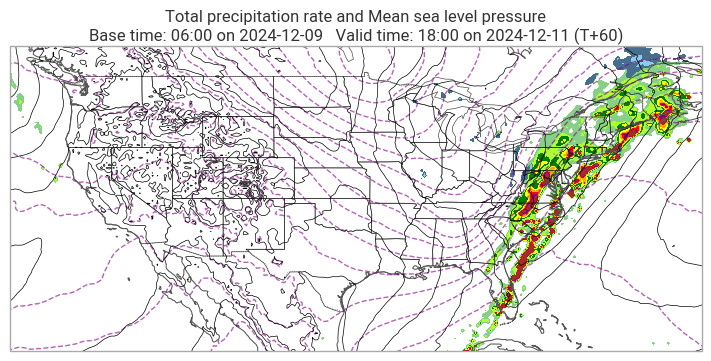

In [88]:
domain_bounds = [-130,-62,22,52]
#domain_bounds = [-140,-60,20,90]
crs = ccrs.PlateCarree()
chart = ekt.plots.Map(domain=domain_bounds, crs=crs)
chart.contourf(prate, style=STYLE_PRATE)
chart.contourf(prate_type_field, style=STYLE_PRATE_SNOW)
#chart.contourf(refc_ice_field, style=STYLE_ICE)
chart.contour(thk1000_500_field, style=STYLE_THK, linewidths=1, linestyles='dashed', alpha=0.6)
chart.contour(msl, style=STYLE_MSLP, linewidths=0.5)

#chart.contour(pressure, units="hPa")
chart.shapes(STATES,  transform=ccrs.PlateCarree(), adjust_labels=False, labels=False, facecolor="none",  # No fill color
    edgecolor="black",  # Blue outline
    linewidth=0.5,     # Line thickness
    alpha=0.7)
chart.shapes(LAKES,  transform=ccrs.PlateCarree(), adjust_labels=False, labels=False, facecolor="none",  # No fill color
    edgecolor="black",  # Blue outline
    linewidth=0.5,     # Line thickness
    alpha=0.7)
try:
    chart.legend(location="bottom")
except:
    print('cannot draw legend')

chart.coastlines()
chart.borders()
#chart.urban_areas()
chart.title()
#chart.gridlines()


chart.show()

In [89]:
valid_time = ts[0].metadata('valid_time')
df = pd.read_csv('data/point/ecmwf/output_data_temp.csv')
df['time'] = pd.to_datetime(df['time'])
df = df[df['time'] == valid_time].reset_index()
gdf = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df['lon'], df['lat']))
print(gdf)
shapefile = 'data/point/ecmwf/output_data_temp.shp'
gdf.to_file(shapefile)



    index  ICAO                time             variable  value      lat  \
0      14  KAEX 2024-12-11 18:00:00  2 metre temperature     54  31.3333   
1      94  KAMA 2024-12-11 18:00:00  2 metre temperature     48  35.2167   
2     174  KWDG 2024-12-11 18:00:00  2 metre temperature     44  36.3667   
3     254  KFSM 2024-12-11 18:00:00  2 metre temperature     45  35.3333   
4     334  KHOB 2024-12-11 18:00:00  2 metre temperature     51  32.6667   
5     414  KJBR 2024-12-11 18:00:00  2 metre temperature     43  35.8333   
6     494  KLAW 2024-12-11 18:00:00  2 metre temperature     50  34.5500   
7     574  KLBB 2024-12-11 18:00:00  2 metre temperature     49  33.6667   
8     654  KMLC 2024-12-11 18:00:00  2 metre temperature     46  34.8833   
9     734  KMAF 2024-12-11 18:00:00  2 metre temperature     51  31.9500   
10    814  KMKO 2024-12-11 18:00:00  2 metre temperature     43  35.6500   
11    894  KOKC 2024-12-11 18:00:00  2 metre temperature     46  35.3833   
12    974  K

/home/jeff/modelgen/.venv/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/home/jeff/modelgen/.venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field time create as date field, though DateTime requested.
  ogr_write(


In [54]:
print(v10_np)

[[[1.95942688 1.95942688 1.95942688 ... 1.95942688 1.95942688 1.95942688]
  [7.45942688 7.47505188 7.47505188 ... 7.44380188 7.44380188 7.45942688]
  [7.45942688 7.45942688 7.45942688 ... 7.42817688 7.44380188 7.44380188]
  ...
  [1.66255188 1.67817688 1.67817688 ... 1.66255188 1.66255188 1.66255188]
  [0.99067688 0.99067688 0.99067688 ... 0.97505188 0.97505188 0.99067688]
  [1.85005188 1.85005188 1.85005188 ... 1.85005188 1.85005188 1.85005188]]]


Text(0.5, 1.0, '100 m wind speed\nBase time: 06:00 on 2024-12-09   Valid time: 18:00 on 2024-12-11 (T+60)')

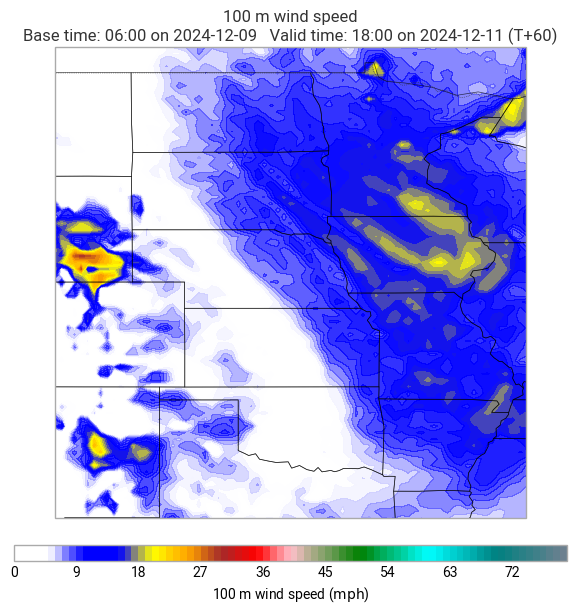

In [104]:
crs = ccrs.PlateCarree()
domain_bounds = [-107,-89,32,50]
chart = ekt.plots.Map(domain=domain_bounds, crs=crs)
#chart.barbs(lon, lat, u10, v10)
#chart.contourf(t2, style=STYLE_2T)
chart.contourf(windsp_field, style=STYLE_WIND)
#chart.barbs(data=None, x=tsuv_x, y=tsuv_y, u=u10_np, v=v10_np)
chart.shapes(STATES,  transform=ccrs.PlateCarree(), adjust_labels=False, labels=False, facecolor="none",  # No fill color
    edgecolor="black",  # Blue outline
    linewidth=0.5,     # Line thickness
    alpha=0.7)

chart.shapes(WINDFARMS,  transform=ccrs.PlateCarree(), adjust_labels=False, gid='O')
#chart.shapes(shapefile,  transform=ccrs.PlateCarree(), adjust_labels=False, labels='value', color='red', facecolor='red')
try:
    chart.legend(location="bottom")
except:
    print('cannot draw legend')
chart.coastlines()
chart.borders()
chart.title()

<xarray.Dataset> Size: 1MB
Dimensions:    (latitude: 180, longitude: 360)
Coordinates:
  * latitude   (latitude) float64 1kB 89.62 88.62 87.62 ... -87.38 -88.38 -89.38
  * longitude  (longitude) float64 3kB -179.6 -178.6 -177.6 ... 178.4 179.4
Data variables:
    100u       (latitude, longitude) float64 518kB -1.531 -1.417 ... -3.78
    100v       (latitude, longitude) float64 518kB 8.002 8.069 ... 0.4212 0.3835
Attributes:
    class:        od
    stream:       scda
    levtype:      sfc
    type:         fc
    expver:       0001
    date:         20241209
    time:         600
    domain:       g
    levelist:     100
    Conventions:  CF-1.8
    institution:  ECMWF


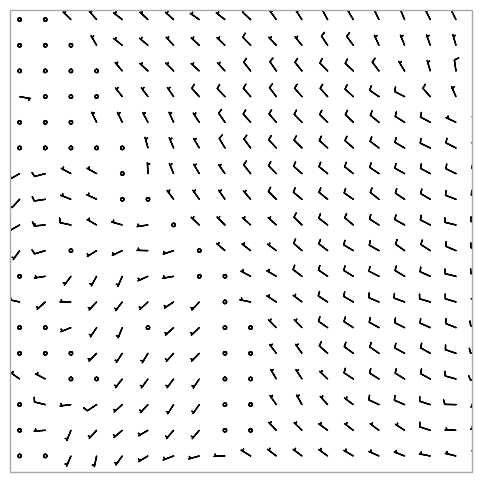

In [97]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
tsuv_xr = tsuv.to_xarray()
tsuv_xr = tsuv_xr.coarsen(latitude=4, longitude=4, boundary='trim').mean()
print(tsuv_xr)
lon = tsuv_xr.longitude.values  # Replace 'longitude' with the actual coordinate name
lat = tsuv_xr.latitude.values   # Replace 'latitude' with the actual coordinate name
u10 = tsuv_xr['100u'].values        # Replace '10u' with the actual variable name
v10 = tsuv_xr['100v'].values
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()})
ax.barbs(lon, lat, u10, v10, length=4)
domain_bounds = [-107,-89,32,50]
ax.add_feature(WINDFARMS)
ax.set_extent(domain_bounds)

In [ ]:
def K_to_F(temp):
    temp = ((temp - 273.15) * (9/5)) + 32
    return temp

tsxr = ts.to_xarray(engine='cfgrib')
df_coords = pd.read_csv('stations.csv')
data = {icao: [] for icao in df_coords['ICAO']}
var_name = '2t'
for index, row in df_coords.iterrows():
    latitude = row['lat']
    longitude = row['lon']
    icao = row['ICAO']
    nearest_value = round(K_to_F(tsxr.sel(latitude=latitude, longitude=longitude, method='nearest').t2m.item()), 0)
    #print(nearest_value)
    # Collect the value, time, and variable for the given ICAO
    data[icao].append({
        'time': valid_time,
        'variable': var_name,
        'value': int(nearest_value),
        'lat': df_coords.loc[df_coords['ICAO'] == icao, 'lat'].values[0],
        'lon': df_coords.loc[df_coords['ICAO'] == icao, 'lon'].values[0],
        'city': df_coords.loc[df_coords['ICAO'] == icao, 'CITY'].values[0],  # Add city
        'state': df_coords.loc[df_coords['ICAO'] == icao, 'STATE'].values[0]  # Add state
    })

print(data)

trows = []
model = 'ecmwf'
var = '2 metre temperature'
# Flatten the data dictionary into the list of rows
for icao, records in data.items():
    for record in records:
        # Append each record as a dictionary to the rows list
        trows.append({
            'ICAO': icao,
            'time': record['time'],
            'variable': record['variable'],
            'value': record['value'],
            'lat': record['lat'],
            'lon': record['lon'],
            'CITY': record['city'],  
            'STATE': record['state'] 
        })
print(trows)

result_df = pd.DataFrame(trows)

if var == 'Maximum temperature':
    var_out = 'maxtemp'
elif var == 'Minimum temperature':
    var_out = 'mintemp'
elif var == '2 metre temperature':
    var_out = 'temp'   
else:
    var_out = var

csv_out = f'data/point/{model}/output_data_{var_out}.csv'
result_df.to_csv(csv_out, index=False)

75.0
52.0
52.0
64.0
68.0
59.0
60.0
60.0
62.0
67.0
61.0
56.0
73.0
57.0
69.0
52.0
48.0
40.0
46.0
49.0
49.0
44.0
48.0
38.0
42.0
49.0
49.0
30.0
25.0
31.0
35.0
33.0
24.0
39.0
30.0
26.0
23.0
33.0
38.0
34.0
{'KAEX': [{'time': '2024-12-09T21:00:00', 'variable': '2t', 'value': 75, 'lat': 31.3333, 'lon': -92.5667, 'city': 'ALEXANDRIA', 'state': 'LA'}], 'KAMA': [{'time': '2024-12-09T21:00:00', 'variable': '2t', 'value': 52, 'lat': 35.2167, 'lon': -101.7167, 'city': 'AMARILLO', 'state': 'TX'}], 'KWDG': [{'time': '2024-12-09T21:00:00', 'variable': '2t', 'value': 52, 'lat': 36.3667, 'lon': -97.7833, 'city': 'ENID', 'state': 'OK'}], 'KFSM': [{'time': '2024-12-09T21:00:00', 'variable': '2t', 'value': 64, 'lat': 35.3333, 'lon': -94.3667, 'city': 'FORT SMITH', 'state': 'AR'}], 'KHOB': [{'time': '2024-12-09T21:00:00', 'variable': '2t', 'value': 68, 'lat': 32.6667, 'lon': -103.2167, 'city': 'HOBBS', 'state': 'NM'}], 'KJBR': [{'time': '2024-12-09T21:00:00', 'variable': '2t', 'value': 59, 'lat': 35.8333, 'l

In [ ]:
#MANUALLY CALCULATING NEAREST GRID POINT WHEN METHOD NEAREST NOT AVAILABLE
# Compute the difference between requested and actual coordinates
diff_lat = abs(tsxr['latitude'] - 35)
diff_lon = abs(tsxr['longitude'] - (-90))

# Find the nearest index
nearest_lat_idx = diff_lat.argmin().values
nearest_lon_idx = diff_lon.argmin().values

# Retrieve the nearest point
nearest_lat = tsxr['latitude'].isel(latitude=nearest_lat_idx)
nearest_lon = tsxr['longitude'].isel(longitude=nearest_lon_idx)

print("Nearest Latitude:", nearest_lat.values)
print("Nearest Longitude:", nearest_lon.values)

# Select the nearest point
point = tsxr.sel(latitude=nearest_lat, longitude=nearest_lon)
print(point)